## Dogs vs. Cats Redux: Kernels Edition
#### - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

### Import Packages

In [2]:
import numpy as np
import pandas as pd
import os, shutil
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from copy import deepcopy
import time
import timm
from efficientnet_pytorch import EfficientNet
import zipfile
import glob
import random
from tqdm import tqdm

### Setup Seed

In [3]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

seed = 42 # 시드값 설정
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) # 해시 시크릿값 고정
np.random.seed(seed) # numpy 난수 생성기
torch.manual_seed(seed) # 파이토치 CPU 난수 생성기
torch.backends.cudnn.deterministic = True # 확정적 연산 사용 설정
torch.backends.cudnn.benchmark = False # 벤치마크 기능 사용 해제 False 이유는 cudnn 알고리즘이 불확실성을 가지고 있다고 해서 끔.
torch.backends.cudnn.enabled = False # cudnn 기능 사용 해제

if device == 'cuda':
    torch.cuda.manual_seed(seed) # 파이토치 GPU 난수 생성기
    torch.cuda.manual_seed(seed) # 파이토치 멀티 GPU 난수 생성기

cuda


### Prepare Data

22500 2500


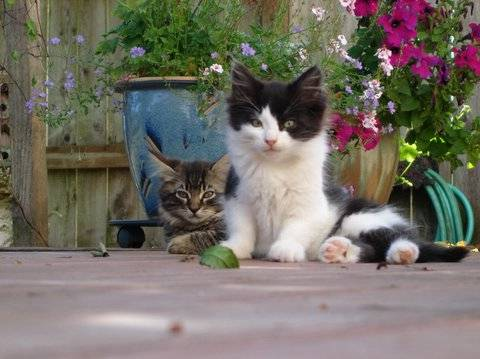

(480, 359)
['./data/train/cat.0.jpg', './data/train/cat.1.jpg', './data/train/cat.10.jpg', './data/train/cat.100.jpg', './data/train/cat.1000.jpg']
['./data/test/1.jpg', './data/test/10.jpg', './data/test/100.jpg', './data/test/1000.jpg', './data/test/10000.jpg']


In [5]:
train_dir = './data/train'
test_dir = './data/test'
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg')) #jpg로 끝나는 파일 전부 불러오기
all_train_files = [path.replace('\\', '/') for path in all_train_files]
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
test_list = [path.replace('\\', '/') for path in test_list]
train_labels = [path.split('/')[-1].split('.')[0] for path in all_train_files] # 파일 이름을 dog 혹은 cat으로만 분류하기
train_list, val_list = train_test_split(all_train_files, test_size=0.1, stratify=train_labels, random_state=seed)
print(len(train_list), len(val_list))
img = Image.open('./data/train/cat.8414.jpg')
#img = Image.open('./data/train\\cat.0.jpg')
#img.show()
display(img)
print(img.size)
print(all_train_files[:5])
print(test_list[:5])


### Prepare Dataset

In [6]:
input_size = 224
transforms_for_train =  transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)), # 이미지를 224로 지정한 후, 0.5~1.0 비율사이로 랜덤으로 이미지 크롭하기
        transforms.RandomHorizontalFlip(),# 좌우반전
        transforms.RandomVerticalFlip(),# 상하반전
        transforms.RandomRotation(10),# 10도 돌리기
        transforms.ToTensor(),# 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# 이미지 체널값 normalization / 표준 편차값 (이미지넷에서 썻던 값) / 사전학습된 데이터와 비슷한 분포를 맞추기 위해서 설정
    ])

transforms_for_val_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#class Dataset
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx] # 파일명 가져와서 
        if img_path.split('/')[-1][-3:] == 'jpg': # 끝이 jpg인지 확인
            img = Image.open(img_path)  # 이미지 열어서,   
            if self.transform is not None:# 지정한 변형 설정이 있으면,
                img_transform = self.transform(img)# 해당 설정한거로 이미지를 변형
                label = img_path.split('/')[-1].split('.')[0]# dog or cat으로 label값 지정
                if label == 'dog':
                  label = 1
                elif label == 'cat':
                  label = 0
        return img_transform, label

dataset_train = CustomDataset(train_list, transform=transforms_for_train)
dataset_valid = CustomDataset(val_list, transform=transforms_for_val_test)
dataset_test = CustomDataset(test_list, transform=transforms_for_val_test)

from torch.utils.data import DataLoader # 데이터 로더 클래스

train_batches = DataLoader(dataset=dataset_train, batch_size=8, shuffle=True)
val_batches = DataLoader(dataset=dataset_valid, batch_size=8, shuffle=False)
test_batches = DataLoader(dataset=dataset_test, batch_size=8, shuffle=False)

In [22]:
# print(test_list[0])
# print(train_list[0])
# print(val_list[0])

### Create Model

In [12]:
model = EfficientNet.from_pretrained('efficientnet-b7')
print(model._fc)
model._fc = nn.Sequential(
    nn.Linear(model._fc.in_features, model._fc.out_features, bias=True), # 입력 차원: 사전학습된 EfficientNet의 마지막 feature 크기 그대로 (2560), 출력 차원: 기존 FC 레이어가 분류하던 클래스 개수 그대로 (1000)
    nn.LeakyReLU(),
    nn.BatchNorm1d(model._fc.out_features), # 1차원이니깐
    nn.Linear(model._fc.out_features, 1, bias=True),
    nn.Sigmoid() # 고양이 아니면 강아지니깐 
)    

model.to(device)
loss_func = nn.BCELoss()
# optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.0001)
# optimizer = torch.optim.Adamax(model.parameters(), lr=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Loaded pretrained weights for efficientnet-b7
Linear(in_features=2560, out_features=1000, bias=True)


In [8]:
model = timm.create_model("vit_base_patch32_224_in21k", pretrained=True)
print(model.head)
model.head = nn.Sequential(
    nn.Linear(768, 21843, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(21843),
    nn.Linear(21843, 512, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 1, bias=True), # Binary Classification 이기 때문에 마지막 뉴런 1
    nn.Sigmoid()
)
model.to(device)
loss_func = nn.BCELoss() # Kaggle 문제 요구사항
# optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.0001)
# optimizer = torch.optim.Adamax(model.parameters(), lr=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

'''
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps = 0, 
  num_training_steps = 10
)
'''

c:\Users\hyuna\anaconda3\envs\pystudy_env\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name vit_base_patch32_224_in21k to current vit_base_patch32_224.augreg_in21k.
  model = create_fn(


Linear(in_features=768, out_features=21843, bias=True)


'\nfrom transformers import get_linear_schedule_with_warmup\nscheduler = get_linear_schedule_with_warmup(\n  optimizer, \n  num_warmup_steps = 0, \n  num_training_steps = 10\n)\n'

### Detail Train Function

In [9]:
def train_model(model, criterion, optimizer, early_stop, epochs, train_loader, valid_loader): # criterion = loss function
     # 손실값, 정확도를 epoch별로 기록할 리스트
    train_losses, train_accuracies, valid_losses, valid_accuracies, lowest_loss, lowest_epoch = list(), list(), list(), list(), np.inf, 0 # np.inf는 무한대(infinity) 를 의미 -> 처음엔 아무 loss보다도 큰 값으로 시작해라. 그래야 처음 loss는 무조건 더 작아서 갱신됨
    
    # DEBUG
    progress_count = 0

    for epoch in range(epochs): # 이번 epoch에서 누적 손실, 정확도 합계, 맞춘 샘플 개수 초기화
        train_loss, train_accuracy, train_corrects, valid_loss, valid_accuracy, valid_corrects = 0, 0, 0, 0, 0, 0
        train_correct, valid_correct = 0, 0 # 각각의 미니배치 마다 몇개를 가져올것인지를 하기위해 0으로 초기화

        start = time.time() # 시간측정
        model.train() # 학습 모드로 전환 (dropout, batchnorm 등 활성화)
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for train_x, train_y in train_pbar:
            train_x = train_x.to(device)# 입력, 타깃 텐서를 GPU로 옮김
            train_y = train_y.to(device).float()# 입력, 타깃 텐서를 GPU로 옮김
            train_y = train_y.view(train_y.size(0), -1)  # 출력이 [batch_size, 1] 모양 되도록 차원 맞춤
            pred = model(train_x)  # forward pass
            loss = criterion(pred, train_y)  # 손실 계산

            optimizer.zero_grad() # optimizer 기울기 초기화
            loss.backward()  # backward pass (gradient 계산)
            optimizer.step() # gradient를 이용해서 파라미터 업데이트
            train_loss += loss.item() # 배치 손실 누적
            
            y_pred = np.round(pred.detach().cpu()) # 예측 확률을 0,1로 반올림해서 binary 결과 얻기
            train_correct += y_pred.eq(train_y.detach().cpu()).sum().item()  # 예측과 정답이 같은 개수 합산
            
            # DEBUG 
            # if (progress_count % 10) == 0:
            #    print (y_pred.eq(train_y.detach().cpu()).sum().item(), len(y_pred))
            # progress_count += 1

             # tqdm 표시줄에 현재 배치의 손실 표시
            train_pbar.set_postfix({
                "loss": f"{loss.item():.4f}"
            })
            

        train_loss = train_loss / len(train_loader) # epoch 평균 손실 계산 (전체 손실 합 / 배치 수)
        train_losses.append(train_loss)
        train_accuracy = train_correct / len(train_loader.dataset)   # epoch 정확도 계산 (맞춘 샘플 수 / 전체 샘플 수)
        train_accuracies.append(train_accuracy)

        model.eval()  # 검증 모드로 전환 (dropout, batchnorm 동작 비활성화)
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]") # tqdm: 검증 데이터 로더에 진행 표시줄 생성
        with torch.no_grad(): # gradient 계산 비활성화
            for valid_x, valid_y in valid_pbar:
                valid_x = valid_x.to(device)
                valid_y = valid_y.to(device).float()
                valid_y = valid_y.view(valid_y.size(0), -1) # 사이즈 맞춤. 이거 실행 안하면 리스트 형태로 (8) 이런식으로 나옴.
                pred = model(valid_x) # forward pass
                loss = criterion(pred, valid_y)
                valid_loss += loss.item() 
            
                y_pred = np.round(pred.detach().cpu()) # 예측을 binary로 반올림
                valid_correct += y_pred.eq(valid_y.detach().cpu()).sum().item() # 예측이 맞은 개수 합산

                valid_pbar.set_postfix({ # tqdm 표시줄에 현재 배치의 손실 표시
                  "loss": f"{loss.item():.4f}"
                })

        valid_loss = valid_loss / len(valid_loader)  # epoch 평균 검증 손실 계산
        valid_losses.append(valid_loss)
        valid_accuracy = valid_correct / len(valid_loader.dataset) # epoch 검증 정확도 계산
        valid_accuracies.append(valid_accuracy)
        
        elapsed_time = time.time() - start # epoch 경과 시간 계산
        print(f'[Epoch {epoch+1}/{epochs}]: {elapsed_time:.3f} sec(elapsed time), train loss: {train_losses[-1]:.4f}, train acc: {train_accuracy * 100:.3f}% / valid loss: {valid_losses[-1]:.4f}, valid acc: {valid_accuracy * 100:.3f}%')

        if valid_losses[-1] < lowest_loss: # validation 손실이 현재까지 최소라면 best 모델 갱신
            lowest_loss = valid_losses[-1] # 더 낮은 validation loss 발견 (이번 epoch의 검증 손실)
            lowest_epoch = epoch # 몇 번째 epoch인지 기억
            best_model = deepcopy(model.state_dict()) # 그때 모델 저장
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch: #patience(=early_stop)만큼 기다렸다가 그래도 개선 안 되면 break로 멈춤 (early stopping)
                print ("Early Stopped", epoch, "epochs")
                break
        
        # scheduler.step()

    model.load_state_dict(best_model) # 학습이 끝난 후 best 모델 로드        
    return model, lowest_loss, train_losses, valid_losses, train_accuracies, valid_accuracies # 모든 결과 반환



In [26]:
model, lowest_loss, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, loss_func, optimizer, 0, 30, train_batches, val_batches) 
#함수 train_model()이 6개 값을 반환
# model->학습할 모델 (예: EfficientNet, ViT 등)
# 손실 함수 (예: nn.BCELoss())
# 옵티마이저 (예: torch.optim.Adam)
# early_stop=0: early stopping 사용 안함
# epochs=30: 전체 에폭을 30번 학습
# train_loader: 학습용 데이터셋 DataLoader
# valid_loader: 검증용 데이터셋 DataLoader

Epoch 1/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.55it/s, loss=0.0772]


[Epoch 1/30]: 1218.170 sec(elapsed time), train loss: 0.2439, train acc: 89.516% / valid loss: 0.0862, valid acc: 97.920%


Epoch 2/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.61it/s, loss=0.0324]


[Epoch 2/30]: 1212.782 sec(elapsed time), train loss: 0.1483, train acc: 94.262% / valid loss: 0.0528, valid acc: 98.600%


Epoch 3/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.62it/s, loss=0.0143]


[Epoch 3/30]: 1210.722 sec(elapsed time), train loss: 0.1119, train acc: 95.880% / valid loss: 0.0395, valid acc: 99.120%


Epoch 4/30 [Valid]: 100%|██████████| 313/313 [01:21<00:00,  3.84it/s, loss=0.0133]


[Epoch 4/30]: 1288.033 sec(elapsed time), train loss: 0.0893, train acc: 97.089% / valid loss: 0.0408, valid acc: 99.080%


Epoch 5/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.65it/s, loss=0.0185]


[Epoch 5/30]: 1619.336 sec(elapsed time), train loss: 0.0785, train acc: 97.516% / valid loss: 0.0317, valid acc: 99.040%


Epoch 6/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.55it/s, loss=0.0089]


[Epoch 6/30]: 1213.292 sec(elapsed time), train loss: 0.0615, train acc: 98.093% / valid loss: 0.0259, valid acc: 99.040%


Epoch 7/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.53it/s, loss=0.0067]


[Epoch 7/30]: 1221.976 sec(elapsed time), train loss: 0.0572, train acc: 98.218% / valid loss: 0.0249, valid acc: 99.160%


Epoch 8/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.58it/s, loss=0.0043]


[Epoch 8/30]: 1212.585 sec(elapsed time), train loss: 0.0462, train acc: 98.556% / valid loss: 0.0229, valid acc: 99.360%


Epoch 9/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.48it/s, loss=0.0040]


[Epoch 9/30]: 1216.678 sec(elapsed time), train loss: 0.0478, train acc: 98.631% / valid loss: 0.0217, valid acc: 99.320%


Epoch 10/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.47it/s, loss=0.0059]


[Epoch 10/30]: 1217.651 sec(elapsed time), train loss: 0.0526, train acc: 98.702% / valid loss: 0.0259, valid acc: 99.280%


Epoch 11/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.55it/s, loss=0.0028]


[Epoch 11/30]: 1212.922 sec(elapsed time), train loss: 0.0385, train acc: 98.889% / valid loss: 0.0210, valid acc: 99.320%


Epoch 12/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.54it/s, loss=0.0021]


[Epoch 12/30]: 1213.495 sec(elapsed time), train loss: 0.0380, train acc: 98.933% / valid loss: 0.0230, valid acc: 99.480%


Epoch 13/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.56it/s, loss=0.0009]


[Epoch 13/30]: 1212.496 sec(elapsed time), train loss: 0.0340, train acc: 98.902% / valid loss: 0.0203, valid acc: 99.400%


Epoch 14/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.60it/s, loss=0.0007]


[Epoch 14/30]: 1211.956 sec(elapsed time), train loss: 0.0360, train acc: 98.911% / valid loss: 0.0202, valid acc: 99.360%


Epoch 15/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.47it/s, loss=0.0011]


[Epoch 15/30]: 1222.392 sec(elapsed time), train loss: 0.0305, train acc: 99.044% / valid loss: 0.0203, valid acc: 99.360%


Epoch 16/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.60it/s, loss=0.0006]


[Epoch 16/30]: 1213.592 sec(elapsed time), train loss: 0.0263, train acc: 99.280% / valid loss: 0.0205, valid acc: 99.320%


Epoch 17/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.61it/s, loss=0.0001]


[Epoch 17/30]: 1210.722 sec(elapsed time), train loss: 0.0337, train acc: 98.893% / valid loss: 0.0174, valid acc: 99.640%


Epoch 18/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.61it/s, loss=0.0003]


[Epoch 18/30]: 1211.722 sec(elapsed time), train loss: 0.0281, train acc: 99.138% / valid loss: 0.0172, valid acc: 99.360%


Epoch 19/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.59it/s, loss=0.0008]


[Epoch 19/30]: 1214.706 sec(elapsed time), train loss: 0.0248, train acc: 99.178% / valid loss: 0.0178, valid acc: 99.480%


Epoch 20/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.65it/s, loss=0.0012]


[Epoch 20/30]: 1214.205 sec(elapsed time), train loss: 0.0314, train acc: 99.107% / valid loss: 0.0199, valid acc: 99.480%


Epoch 21/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.69it/s, loss=0.0002]


[Epoch 21/30]: 1210.852 sec(elapsed time), train loss: 0.0301, train acc: 99.151% / valid loss: 0.0166, valid acc: 99.600%


Epoch 22/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.64it/s, loss=0.0002]


[Epoch 22/30]: 1211.460 sec(elapsed time), train loss: 0.0297, train acc: 99.147% / valid loss: 0.0185, valid acc: 99.480%


Epoch 23/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.57it/s, loss=0.0005]


[Epoch 23/30]: 1211.361 sec(elapsed time), train loss: 0.0226, train acc: 99.191% / valid loss: 0.0185, valid acc: 99.480%


Epoch 24/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.55it/s, loss=0.0004]


[Epoch 24/30]: 1212.559 sec(elapsed time), train loss: 0.0244, train acc: 99.151% / valid loss: 0.0184, valid acc: 99.520%


Epoch 25/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.56it/s, loss=0.0001]


[Epoch 25/30]: 1212.538 sec(elapsed time), train loss: 0.0214, train acc: 99.253% / valid loss: 0.0224, valid acc: 99.480%


Epoch 26/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.57it/s, loss=0.0009]


[Epoch 26/30]: 1214.823 sec(elapsed time), train loss: 0.0300, train acc: 99.271% / valid loss: 0.0190, valid acc: 99.480%


Epoch 27/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.52it/s, loss=0.0001]


[Epoch 27/30]: 1212.047 sec(elapsed time), train loss: 0.0171, train acc: 99.387% / valid loss: 0.0193, valid acc: 99.440%


Epoch 28/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.54it/s, loss=0.0002]


[Epoch 28/30]: 1214.199 sec(elapsed time), train loss: 0.0212, train acc: 99.320% / valid loss: 0.0189, valid acc: 99.440%


Epoch 29/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.51it/s, loss=0.0002]


[Epoch 29/30]: 1215.215 sec(elapsed time), train loss: 0.0235, train acc: 99.342% / valid loss: 0.0193, valid acc: 99.520%


Epoch 30/30 [Valid]: 100%|██████████| 313/313 [00:36<00:00,  8.53it/s, loss=0.0000]

[Epoch 30/30]: 1216.275 sec(elapsed time), train loss: 0.0165, train acc: 99.409% / valid loss: 0.0222, valid acc: 99.400%


### Save Model

In [ ]:
# PATH = './save_model/dog_vs_cat/'
# torch.save(model.state_dict(), PATH + 'model_vit_base_patch32_224_in21k_without_scheduler_adam_1e5_epoch30.pth')  # 모델 객체의 state_dict 저장
# # model.state_dict(): 모델 내부에 학습된 모든 **가중치(weights)**와 바이어스(bias) 값들을 딕셔너리 형태로 가져옴.
# # torch.save(...): 지정된 경로에 파일로 저장함.

In [17]:
# PATH = './save_model/dog_vs_cat/'
# torch.save(model.state_dict(), PATH + 'model_efficientnet-b7_without_scheduler_adam_1e5_epoch30.pth')  # 모델 객체의 state_dict 저장

### Load Model

In [13]:
model_efficientb7 = deepcopy(model)
PATH = './save_model/dog_vs_cat/'
model_efficientb7.load_state_dict(torch.load(PATH + 'model_efficientnet-b7_without_scheduler_adam_1e5_epoch30.pth'))

<All keys matched successfully>

In [ ]:
# model_vit = deepcopy(model)
# PATH = './save_model/dog_vs_cat/'
# model_vit.load_state_dict(torch.load(PATH + 'model_vit_base_patch32_224_in21k_without_scheduler_adam_1e5_epoch30.pth'))

model_vit = timm.create_model("vit_base_patch32_224_in21k", pretrained=True) # 훈련할 때와 똑같이 ViT 모델 생성

model_vit.head = nn.Sequential( # head를 훈련할 때와 동일하게 바꾼다
    nn.Linear(768, 21843, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(21843),
    nn.Linear(21843, 512, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 1, bias=True),
    nn.Sigmoid()
)

model_vit = model_vit.to(device)
PATH = './save_model/dog_vs_cat/model_vit_base_patch32_224_in21k_without_scheduler_adam_1e5_epoch30.pth' # 저장한 state_dict 경로
state_dict = torch.load(PATH) # state_dict 로드
model_vit.load_state_dict(state_dict) # 로드
print("model loaded")

✅ 모델 로드 성공!


### Predict & Submit

In [15]:
test_list = glob.glob(os.path.join(test_dir, '*.jpg')) # test_dir 폴더에 있는 *.jpg 파일 경로를 모두 리스트로 가져옴.
dataset_test = CustomDataset(test_list, transform=transforms_for_val_test) # CustomDataset 클래스를 이용해서 테스트셋을 만듦. test_list: 이미지 경로 리스트, transform=transforms_for_val_test: 테스트 시에 쓸 이미지 전처리(transform)
test_batches = DataLoader(dataset=dataset_test, batch_size=8, shuffle=False) # 위 데이터셋을 DataLoader에 넣어 한 번에 8장씩 가져오도록 만듦.

def predict(model, data_loader): # 모델과 DataLoader를 받아서 예측값을 반환하는 함수 선언
    ids = list() #결과에 각 파일 이름(ID)을 저장할 리스트 생성
    with torch.no_grad():
        model.eval() #평가모드 전환
        ret = None #예측 결과를 저장할 변수 (처음엔 None)
        for img, fileid in tqdm(data_loader,desc="Predicting"): #DataLoader에서 배치 단위로 (이미지 텐서, 파일 이름) 꺼내옴 img: (8, C, H, W) 텐서 fileid: 이미지 파일 이름 리스트
            img = img.to(device) # 이미지를 GPU로 옮김
            pred = model(img) # 모델에 이미지를 넣어 예측값(출력)을 구함 예: (8, 1) 시그모이드 확률 값
            ids += list(fileid) # 이번 배치의 파일 이름을 ids에 누적 저장
            if ret is None: #첫 번째 배치라면
                ret = pred.cpu().numpy() # 예측 결과를 CPU로 옮겨 numpy 배열로 변환해 ret에 저장
            else: #두 번째 배치부터는
                ret = np.vstack([ret, pred.cpu().numpy()]) #이전 결과들과 현재 배치를 수직으로 쌓아 하나의 배열로 만듦
    return ret, ids # 최종적으로 모든 배치의 예측 결과(ret)와 파일 이름 리스트(ids)를 반환

In [16]:
pred_efficientb7, ids_efficientb7 = predict(model_efficientb7, test_batches) #model_efficientb7 (EfficientNet 모델)을 사용해서 테스트 데이터셋(test_batches)에 대해 예측을 수행/ predict() 함수가 실행됩니다. pred_efficientb7: 각 이미지에 대한 예측 확률 (예: [0.9, 0.1, ...]) ids_efficientb7: 각 이미지 파일 이름 리스트 (예: ['cat.1.jpg', 'dog.2.jpg', ...])
pred_vit, ids_vit = predict(model_vit, test_batches) #동일

Predicting: 100%|██████████| 1563/1563 [00:57<00:00, 27.26it/s]


### ENSEMBLE
🧮 왜 0.7과 0.3을 곱하나?
이건 **가중 평균(weighted average)**이라고 불러요.
간단히 말해:

두 모델의 신뢰도를 다르게 두고 합치는 것.

비유
EfficientNet은 내가 여러 실험을 해보니 정확도가 더 높아.

ViT도 좋은데 EfficientNet보단 살짝 떨어져.

그렇다면 EfficientNet의 결과를 좀 더 많이 반영하고 싶어.

그래서:

EfficientNet 예측에 0.7 (비중 70%)

ViT 예측에 0.3 (비중 30%)

이렇게 비율을 다르게 곱해서 평균을 냅니다.

In [18]:
print(pred_efficientb7)

[[1.0000000e+00]
 [2.2851348e-06]
 [1.6247860e-08]
 ...
 [1.0000000e+00]
 [1.4787291e-07]
 [1.3730029e-04]]


In [19]:
pred_ensemble = np.mean([pred_efficientb7 * 0.7, pred_vit * 0.3], axis=0)
ids = ids_vit

### Submission

In [20]:
submission = pd.DataFrame({'id': ids, 'label': np.clip(pred_ensemble, 0.005, 1-0.005).squeeze()}) #'id': 이미지 파일 이름 리스트(ids)를 넣음., 'label': 예측값을 넣는데, pred_ensemble 값이 너무 극단적(0 또는 1)이면 불안정할 수 있으니, np.clip()으로 0.005 ~ 0.995 범위로 잘라줌. 예: 0이면 0.005로, 1이면 0.995로 바꿈., .squeeze()는 (N, 1) 차원을 (N,)로 차원 축소해 1차원 배열로 만듦.
submission.sort_values(by='id', inplace=True) # id(파일명)를 기준으로 오름차순 정렬. 예를 들어 cat.1.jpg, cat.2.jpg, cat.3.jpg 순서로 정렬해서 제출 결과가 일관되도록 함. inplace=True로 DataFrame 자체를 바로 정렬.
submission.reset_index(drop=True, inplace=True) # 정렬 후 기존 인덱스를 제거하고 새로운 연속 인덱스를 부여. drop=True: 기존 인덱스는 버림. inplace=True: DataFrame에 즉시 반영.
submission.to_csv('submission.csv', index=False) # submission DataFrame을 submission.csv 파일로 저장. index=False: 행 번호 인덱스는 저장하지 않음. 제출용 CSV에 필요 없는 인덱스가 포함되지 않도록.

### Test for Optimal Ensemble

In [21]:
pred_ensemble = pred_efficientb7 * 0.9 + pred_vit * 0.1

In [22]:
submission = pd.DataFrame({'id': ids, 'label': np.clip(pred_ensemble, 0.005, 1-0.005).squeeze()})
submission.sort_values(by='id', inplace=True) 
submission.reset_index(drop=True, inplace=True) 
submission.to_csv('submission_v2.csv', index=False) 